In [1]:
import stim, pymatching as pm, numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

## Noisy repetition code (3 data qubits, 2 ancillas) with detectors

This Stim snippet builds a **repetition code** on qubits `0..4` (data: `0,2,4`; ancillas: `1,3`) with **5 syndrome rounds** and a final data readout. It includes:
- **Noise:** `X_ERROR`, `DEPOLARIZE1/2` around CNOT layers each round.
- **Syndrome extraction:** measure ancillas (`M 1 3`) each round.
- **Detectors:** first round seeds detectors; in the loop, detectors use **time-differences** (e.g., `rec[-2] rec[-4]`) to cancel measurement noise.
- **SHIFT_COORDS:** advances the time axis for clean timeline plotting (`DETECTOR(x, t)`).
- **Final step:** measure data (`M 0 2 4`), add bridging detectors to the final round, and define **one logical observable** via `OBSERVABLE_INCLUDE(0) rec[-1]` (the last measured data bit).


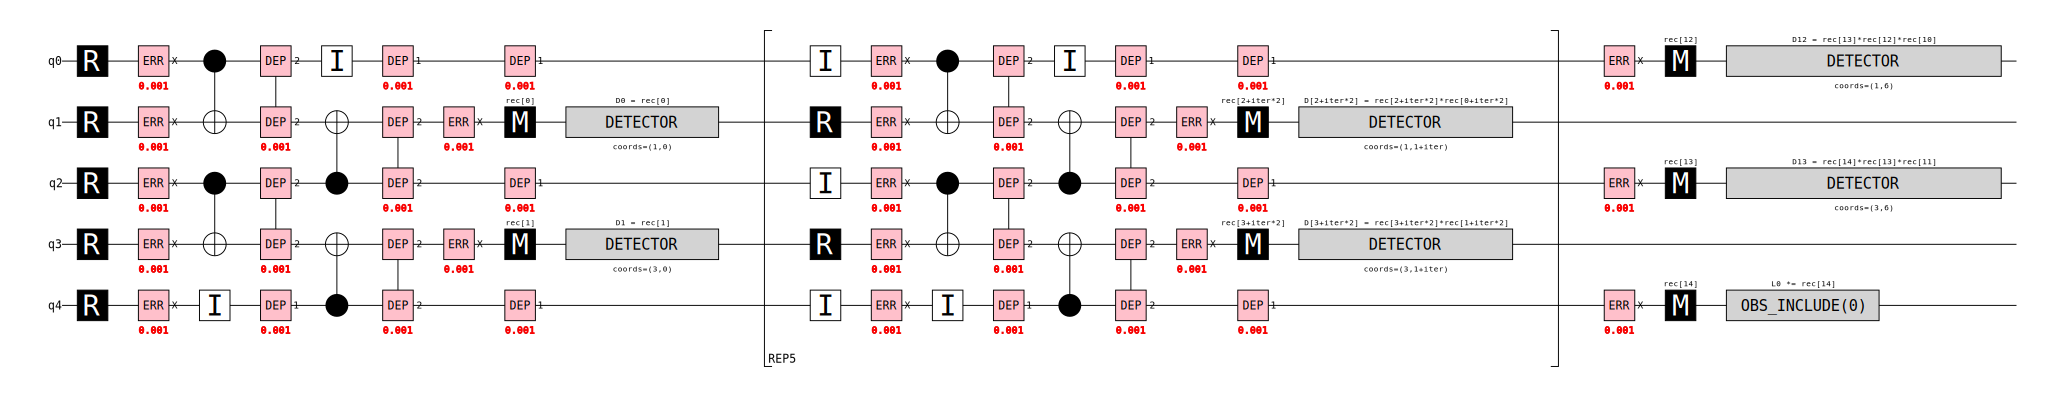

In [2]:
circ_str = """
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    CX 0 1 2 3
    I 4
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    CX 2 1 4 3
    I 0
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    REPEAT 5 {
        R 1 3
        I 0 2 4
        X_ERROR(0.001) 0 1 2 3 4
        CX 0 1 2 3
        I 4
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        CX 2 1 4 3
        I 0
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]

    OBSERVABLE_INCLUDE(0) rec[-1]
"""
c = stim.Circuit(circ_str)
display(SVG(str(c.diagram("timeline"))))

## Generalized Repetition Code with Realistic Noise

This circuit is a **generalization of the previous repetition code example**.  
Instead of hardcoding a small layout, we now construct a **distance-d repetition code** with arbitrary rounds and realistic noise channels.

Key features:
- **Parameterization:** works for any odd distance `d`, number of rounds, and noise strength `p`.  
- **Noise model:** includes `X_ERROR`, `DEPOLARIZE1`, and `DEPOLARIZE2` at each stage (initialization, gates, measurements).  
- **Repeating rounds:** the helper `repeating_part` builds a single noisy syndrome round; the full circuit stacks `rounds` copies.  
- **Detectors:** track time-correlated syndrome differences using `SHIFT_COORDS`.  
- **Observable:** the logical value of the repetition code is defined via `OBSERVABLE_INCLUDE`.  

Below, we generate and visualize the **timeline** and **timeslice** diagrams for `d = 3`, `p = 0.002`, and `rounds = 5`.


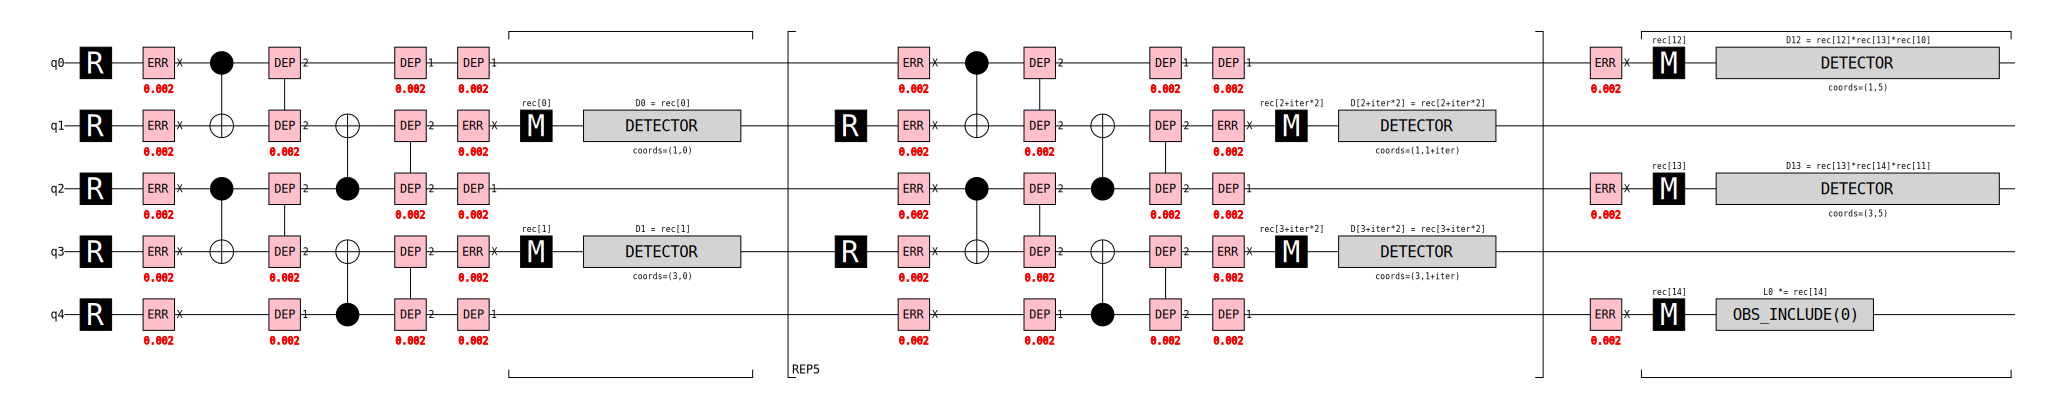

In [3]:
def repeating_part(d: int, p: float, n: int, qubits, q_dat, q_meas) -> stim.Circuit:
    c = stim.Circuit()
    c.append("R", q_meas)
    c.append("TICK")
    for i in qubits:
        c.append("X_ERROR", [i], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    c.append("TICK")
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    c.append("TICK")
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    c.append("TICK")
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    c.append("TICK")
    for i in q_meas:
        c.append("M", [i])
    c.append("TICK")
    c.append("SHIFT_COORDS", [], [0, 1])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])

    return c

def repetition_circuit_realistic_noise(d: int, p: float, rounds: int) -> stim.Circuit:
    n = d * 2 - 1
    c = stim.Circuit()
    qubits = range(n)
    q_dat = qubits[::2]
    q_meas = qubits[1::2]
    c.append("R", range(n))
    c.append("TICK")
    c.append("X_ERROR", range(n), p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    c.append("TICK")
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    c.append("TICK")
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    c.append("TICK")
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    c.append("TICK")
    for i in q_meas:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])
    c.append("TICK")
    c += rounds*repeating_part(d, p, n, qubits, q_dat, q_meas)
    
    for i in q_dat:
        c.append("X_ERROR", [i], p)
    c.append("TICK")
    for i in q_dat:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(- d + int(i/2)), stim.target_rec(- d + int(i/2) + 1), stim.target_rec(- d + int(i/2) - d + 1)], [i,0])
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)
    return c

d = 3

p = 0.002
rounds = 5
c = repetition_circuit_realistic_noise(d, p, rounds)

display(SVG(str(c.diagram("timeline"))))

## Timeslice Diagram

The **timeslice diagram** shows the circuit laid out in *layers of simultaneous operations*.  
- Each vertical slice corresponds to a **moment in time** when a set of gates or noise channels act in parallel.  
- Data qubits and measurement qubits are placed on horizontal lines, with operations stacked in order.  
- This view emphasizes the **gate scheduling**: which operations commute and can be executed in the same tick.  
- Unlike the timeline diagram (which stretches events along a time axis), the timeslice diagram is compact and highlights the **parallel structure** of each round.  


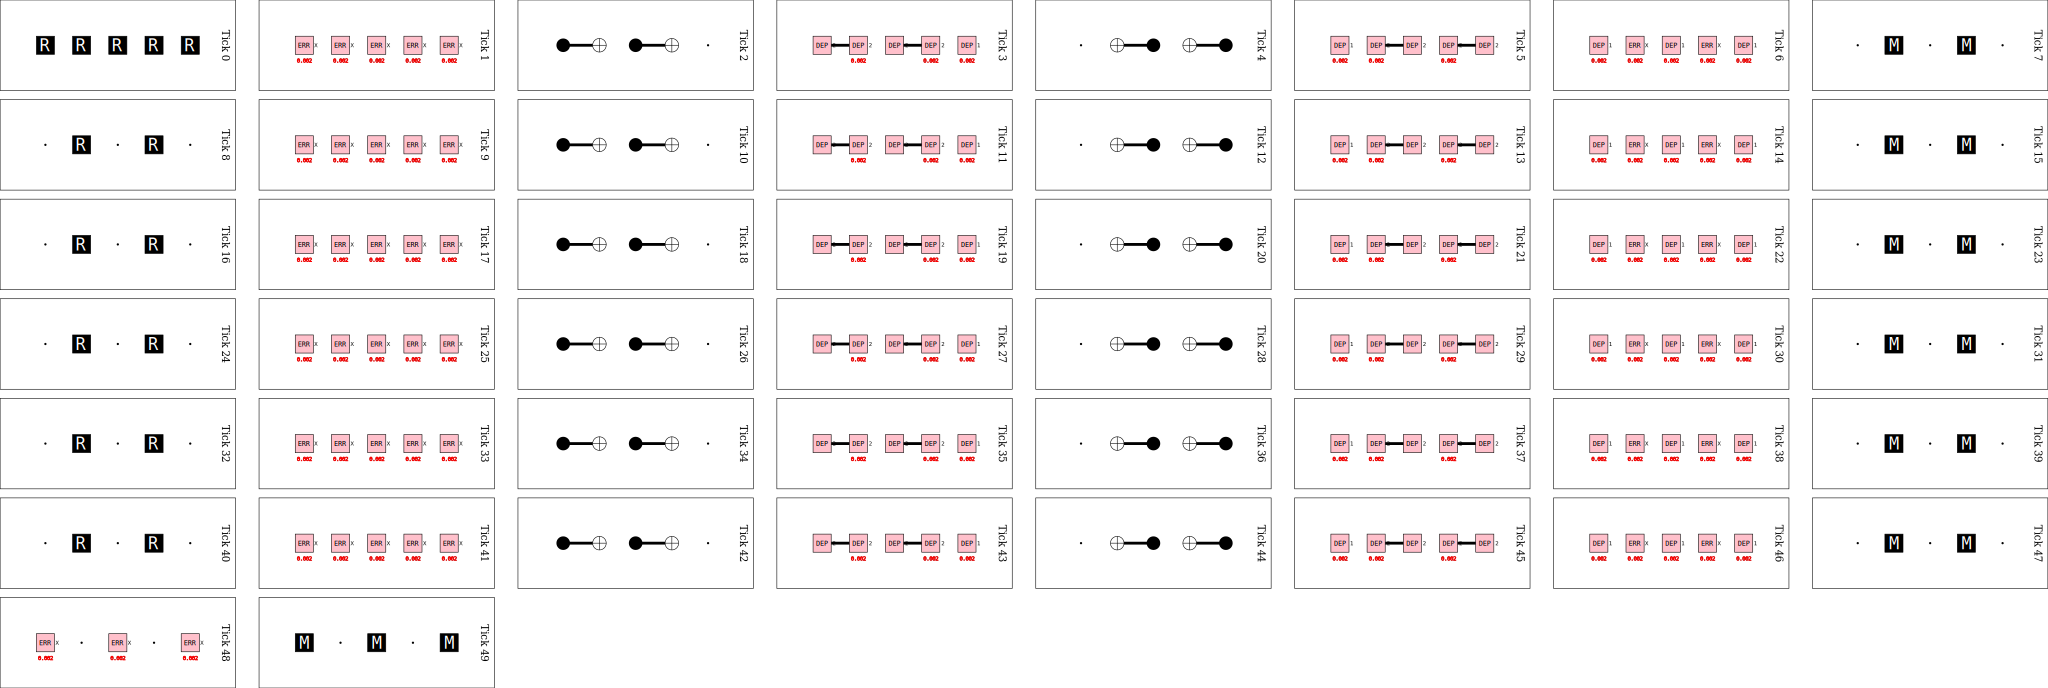

In [4]:
display(SVG(str(c.diagram("timeslice-svg"))))

## Detector Error Model (DEM)

Here we extract the **detector error model** from the circuit.  
The DEM is a compact description of how physical noise (Pauli errors, depolarization, etc.) maps to **detectors** and **logical observables**.  

Printing `repr(dem)` shows the text form of the model, listing:
- **error probabilities** attached to combinations of detectors and observables,  
- the structure the decoder (e.g., PyMatching) will use to infer corrections.  


In [5]:
dem = c.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.00505015) D0
    error(0.00253148) D0 D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D0 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00253148) D0 D2 D4 D6 D8 D10
    error(0.00505015) D1
    error(0.00385807) D1 D3 D5 D7 D9 D11 L0
    error(0.00505015) D2
    error(0.00438757) D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D2 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.0057092) D2 D4 D6 D8 D10
    error(0.00505015) D3
    error(0.0057092) D3 D5 D7 D9 D11 L0
    error(0.00505015) D4
    error(0.00438757) D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D4 D6 D7 D8 D9 D10 D11
    error(0.0057092) D4 D6 D8 D10
    error(0.00505015) D5
    error(0.0057092) D5 D7 D9 D11 L0
    error(0.00505015) D6
    error(0.00438757) D6 D7 D8 D9 D10 D11
    error(0.00106667) D6 D8 D9 D10 D11
    error(0.0057092) D6 D8 D10
    error(0.00505015) D7
    error(0.0057092) D7 D9 D11 L0
    error(0.00505015) D8
    error(0.00438757) D8 D9 D10 D11
    error(0.00570

## Counting Logical Errors with PyMatching

This function simulates the circuit many times and uses **PyMatching** to decode.  

Steps:
1. **Sample the circuit:**  
   Use Stim’s detector sampler to generate `detection_events` (syndromes) and `observable_flips` (true logical outcomes) for `num_shots`.  

2. **Build the decoder:**  
   Extract the **detector error model (DEM)** from the circuit and feed it into PyMatching to create a minimum-weight perfect matching decoder.  

3. **Decode the data:**  
   Run `matcher.decode_batch` on all detection events to get the decoder’s predictions of logical flips.  

4. **Compare with ground truth:**  
   For each shot, compare predicted vs actual observables.  
   If they differ, that shot is a **logical error**.  

5. **Return total errors:**  
   The function outputs the number of decoding failures across all trials.


In [16]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pm.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

d = 7
p = 0.002
rounds = 5
circuit = repetition_circuit_realistic_noise(d, p, rounds)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 10 wrong predictions (logical errors) out of 100000 shots


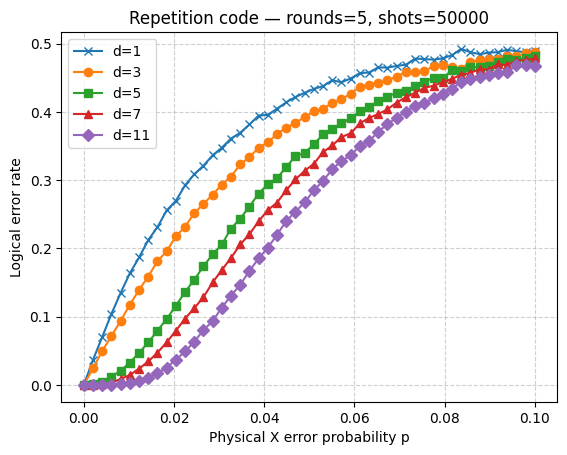

In [7]:
# Parameters
rounds = 5
num_shots = 50000
ps = np.linspace(0.0, 0.10, 50)   # noise strengths

results = {}

for d in [1, 3, 5, 7, 11]:
    rates = []
    for p in ps:
        c = repetition_circuit_realistic_noise(d, p, rounds)
        errors = count_logical_errors(c, num_shots)
        rate = errors / num_shots
        rates.append(rate)
    results[d] = rates

# Plot both distances
plt.figure()
plt.plot(ps, results[1], marker="x", label="d=1")
plt.plot(ps, results[3], marker="o", label="d=3")
plt.plot(ps, results[5], marker="s", label="d=5")
plt.plot(ps, results[7], marker="^", label="d=7")
plt.plot(ps, results[11], marker="D", label="d=11")
plt.xlabel("Physical X error probability p")
plt.ylabel("Logical error rate")
plt.title(f"Repetition code — rounds={rounds}, shots={num_shots}")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## Saturation of Logical Error Rates

The plot shows the **logical error rate** versus the **physical X error probability** \(p\) for repetition codes of distances \(d = 1, 3, 5, 7, 11\), with 5 rounds and 50,000 shots.

**Key observation:**
- For any code distance, as the physical error probability increases, the logical error rate **saturates around 50%**.  
- This reflects that once noise becomes too strong, the logical measurement is no better than a random guess.  
- Larger distances delay the onset of this saturation, but cannot prevent it — consistent with the fact that the **1D repetition code has no finite threshold**.


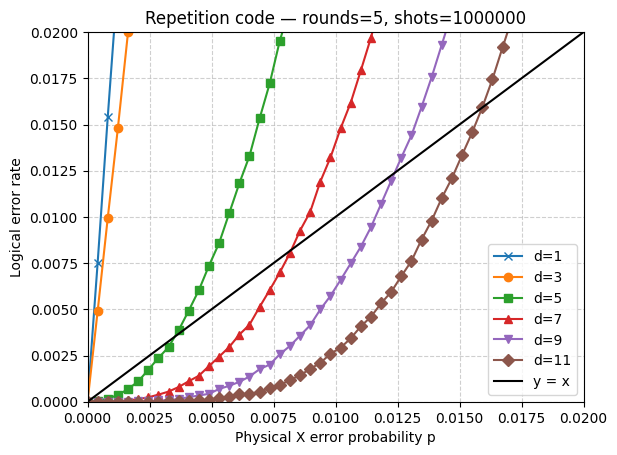

In [13]:
# Parameters
rounds = 5
num_shots = 1_000_000
x_range = 0.02
n_intervals = 50
ps = np.linspace(0.0, x_range, n_intervals)   # noise strengths

results = {}

for d in [1, 3, 5, 7, 9, 11]:
    rates = []
    for p in ps:
        c = repetition_circuit_realistic_noise(d, p, rounds)
        errors = count_logical_errors(c, num_shots)
        rate = errors / num_shots
        rates.append(rate)
    results[d] = rates

# Plot both distances
plt.figure()
plt.plot(ps, results[1], marker="x", label="d=1")
plt.plot(ps, results[3], marker="o", label="d=3")
plt.plot(ps, results[5], marker="s", label="d=5")
plt.plot(ps, results[7], marker="^", label="d=7")
plt.plot(ps, results[9], marker="v", label="d=9")
plt.plot(ps, results[11], marker="D", label="d=11")

# Add reference line y = x
plt.plot(ps, ps, color="black", linestyle="-", label="y = x")

plt.xlabel("Physical X error probability p")
plt.ylabel("Logical error rate")
plt.title(f"Repetition code — rounds={rounds}, shots={num_shots}")
plt.xlim(0, x_range)
plt.ylim(0, x_range)   # make y range same as x range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


## Break-Even Behavior of Repetition Codes

This plot compares logical vs physical error rates for distances \(d = 1, 3, 5, 7, 9, 11\) with 5 rounds and 1,000,000 shots.

**Observations:**
- For **small codes** (\(d=1\) and \(d=3\)), the logical error rate is **always above the physical error line \(y=x\)**, meaning these codes actually *worsen* performance at any realistic physical error rate.
- Starting at **\(d=5\)**, the curves cross the line \(y=x\). This defines a **break-even probability**:  
  - Below this \(p\), the code improves reliability (logical error < physical error).  
  - Above it, the code degrades performance.  
- As distance increases (\(d=7, 9, 11\)), the break-even probability **shifts to larger values of \(p\)**, showing stronger suppression of logical errors.

**Takeaway:**  
Only **distance-5 and higher** repetition codes start to offer net benefits, and higher distances progressively extend the regime where error correction is effective.
